<a href="https://colab.research.google.com/github/Galliano13/Lung-Disease-Detection/blob/main/Lung_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. IMPORT LIBRARIES AND DATASET

In [12]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [13]:
X_Ray_Directory = '/content/drive/MyDrive/LungModel/LungDataset/Dataset'

In [14]:
os.listdir(X_Ray_Directory)

['3', '2', '1', '0']

In [15]:
test_directory = '/content/drive/MyDrive/LungModel/LungTest/Test'
print(f"Test directory set to: {test_directory}")

Test directory set to: /content/drive/MyDrive/LungModel/LungTest/Test


# 3. VISUALIZE DATASET

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enhanced augmentation to prevent overfitting
image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Initialize generators
train_generator = image_generator.flow_from_directory(
    X_Ray_Directory,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = image_generator.flow_from_directory(
    X_Ray_Directory,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 437 images belonging to 4 classes.
Found 106 images belonging to 4 classes.


In [63]:
# labels Translator
label_names = { 0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

IndexError: index 32 is out of bounds for axis 0 with size 32

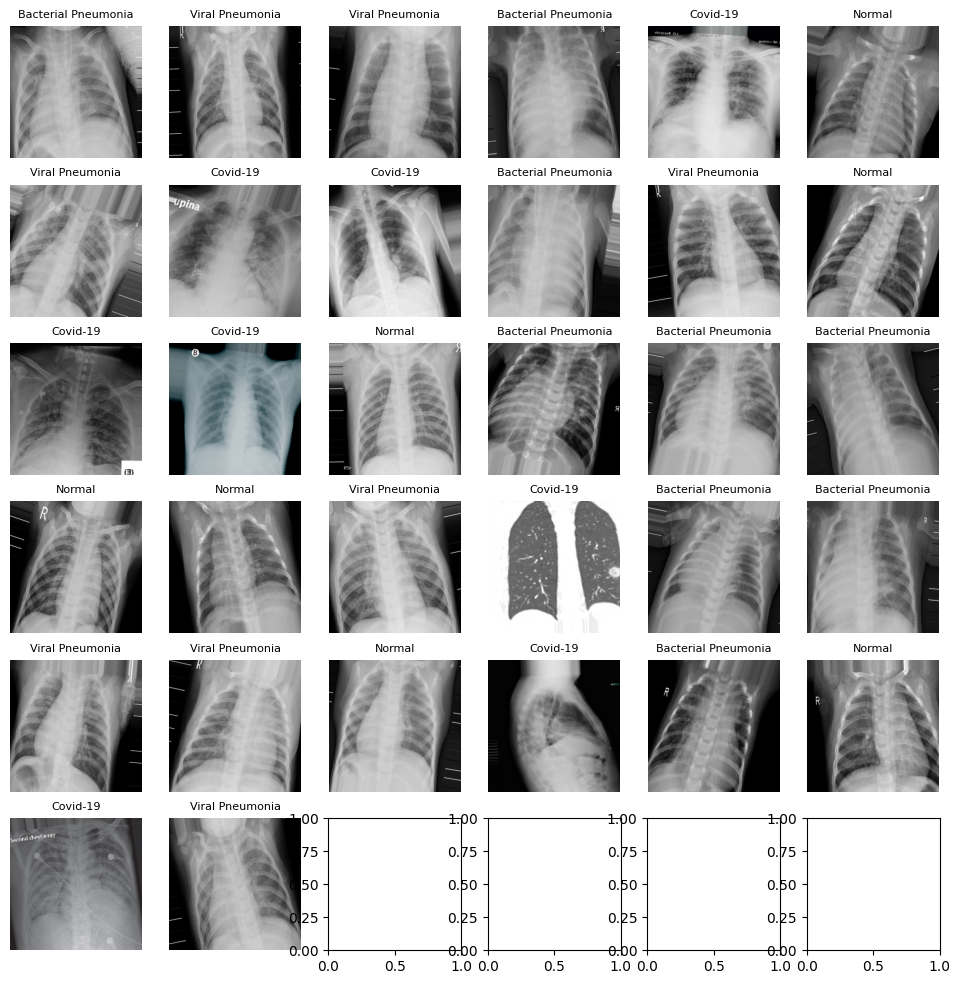

In [64]:
fresh_train_images, fresh_train_labels = next(train_generator)

L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(fresh_train_images[i])
    # This line now looks up the string name from the dictionary
    label_index = np.argmax(fresh_train_labels[i])
    axes[i].set_title(label_names[label_index], fontsize=8)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

# 4. IMPORT MODEL WITH PRETRAINED WEIGHTS

In [65]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [66]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# 5. BUILD AND TRAIN DEEP LEARNING MODEL

In [67]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten (name = 'flatten') (headmodel)
headmodel = Dense(256, activation = 'relu') (headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu') (headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax') (headmodel)

In [68]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [69]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

# 6. EVALUATE TRAINED DEEP LEARNING MODEL

In [70]:
image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [71]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Adjust EarlyStopping callback
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=10)

# Adjust ModelCheckpoint callback
checkpointer = ModelCheckpoint(filepath='best_model_weights.keras', verbose=1, save_best_only=True)

print("Learning rate scheduler and callbacks defined successfully.")

Learning rate scheduler and callbacks defined successfully.


In [72]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])
print("Model recompiled with updated learning rate.")

Model recompiled with updated learning rate.


## Unfreeze More Layers for Fine-tuning


In [73]:
for layer in basemodel.layers:
    layer.trainable = True

print("All layers in the basemodel are now unfrozen and trainable.")

All layers in the basemodel are now unfrozen and trainable.


## Re-Train the Model


In [74]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory=X_Ray_Directory, shuffle=True, target_size=(256, 256), class_mode='categorical', subset='training')
validation_generator = image_generator.flow_from_directory(batch_size=4, directory=X_Ray_Directory, shuffle=True, target_size=(256, 256), class_mode='categorical', subset='validation')

print("Train and validation generators re-initialized with enhanced augmentation.")

Found 437 images belonging to 4 classes.
Found 106 images belonging to 4 classes.
Train and validation generators re-initialized with enhanced augmentation.


In [75]:
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[checkpointer, earlystopping, lr_scheduler])
print("Model training initiated with updated callbacks.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5034 - loss: 1.2420
Epoch 1: val_loss improved from inf to 4.10764, saving model to best_model_weights.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 84s 380ms/step - accuracy: 0.5045 - loss: 1.2395 - val_accuracy: 0.2453 - val_loss: 4.1076 - learning_rate: 1.0000e-04
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6820 - loss: 0.7767
Epoch 2: val_loss did not improve from 4.10764
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.6824 - loss: 0.7762 - val_accuracy: 0.2453 - val_loss: 13.1239 - learning_rate: 1.0000e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7806 - loss: 0.6021
Epoch 3: val_loss did not improve from 4.10764
110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - accuracy: 0.7807 - loss: 0.6022 - val_accuracy: 0.2453 - val_loss: 235.7404 - learning_rate: 1.0000e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8530 - loss: 0.4146
Epoch 4: val_loss 

## Evaluate Model Performance

## Data Visualizations

### Visualize Class Distribution


/tmp/ipython-input-3949290591.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette='viridis')


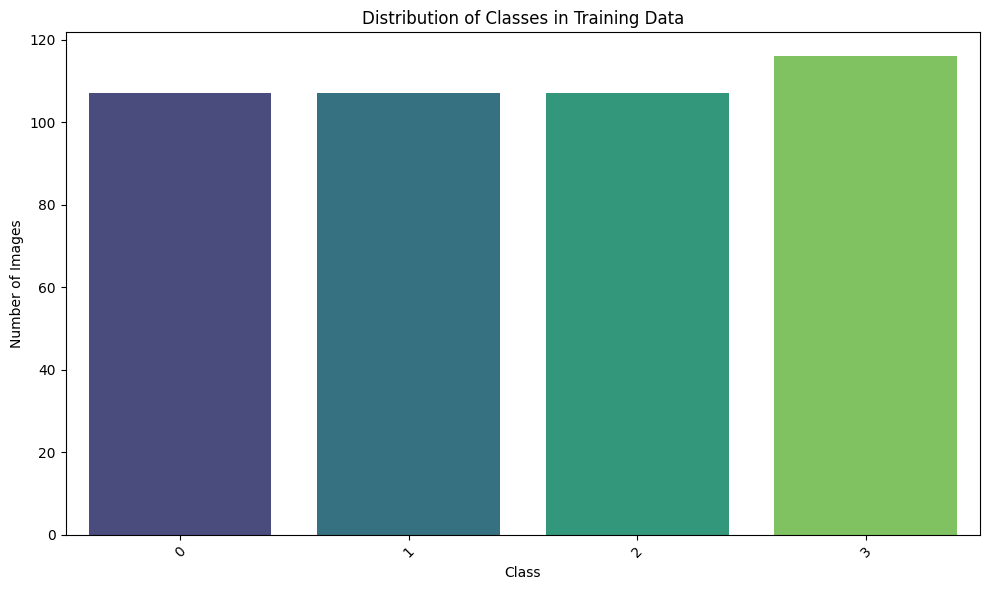

In [76]:
class_counts = {class_name: 0 for class_name in train_generator.class_indices.keys()}

for i in range(len(train_generator)):
    _, labels = next(train_generator)
    for label_one_hot in labels:
        class_idx = np.argmax(label_one_hot)
        class_name = list(train_generator.class_indices.keys())[class_idx]
        class_counts[class_name] += 1

class_names = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=counts, palette='viridis')
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualize Classification Report


In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Initialize the Generator for testing (only rescaling, no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Create the test_generator
# Ensure 'X_Ray_Directory' points to your test folder or the main dataset folder
test_generator = test_datagen.flow_from_directory(
    X_Ray_Directory,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # CRITICAL: Keep False for classification reports
)

# 3. Now define your classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

Found 543 images belonging to 4 classes.


In [78]:
import numpy as np
from sklearn.metrics import classification_report

# 1. Get the true labels from the generator
# Assuming 'test_generator' is your data loader
true_classes = test_generator.classes

# 2. Get the class names (Covid-19, Normal, etc.)
class_labels = list(test_generator.class_indices.keys())

# 3. Use the model to predict the classes
# This may take a moment depending on the size of your test set
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# 4. Now your report code will work
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Remove 'accuracy', 'macro avg', 'weighted avg' from report for plotting
report.pop('accuracy', None)
report.pop('macro avg', None)
report.pop('weighted avg', None)

print("Report generated successfully.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 639ms/step
Report generated successfully.


/tmp/ipython-input-3880673216.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y='precision', data=metrics_df, ax=ax[0], palette='coolwarm')
/tmp/ipython-input-3880673216.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y='recall', data=metrics_df, ax=ax[1], palette='coolwarm')
/tmp/ipython-input-3880673216.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y='f1-score', data=metrics_df, ax=ax[2], palette='coolwarm')


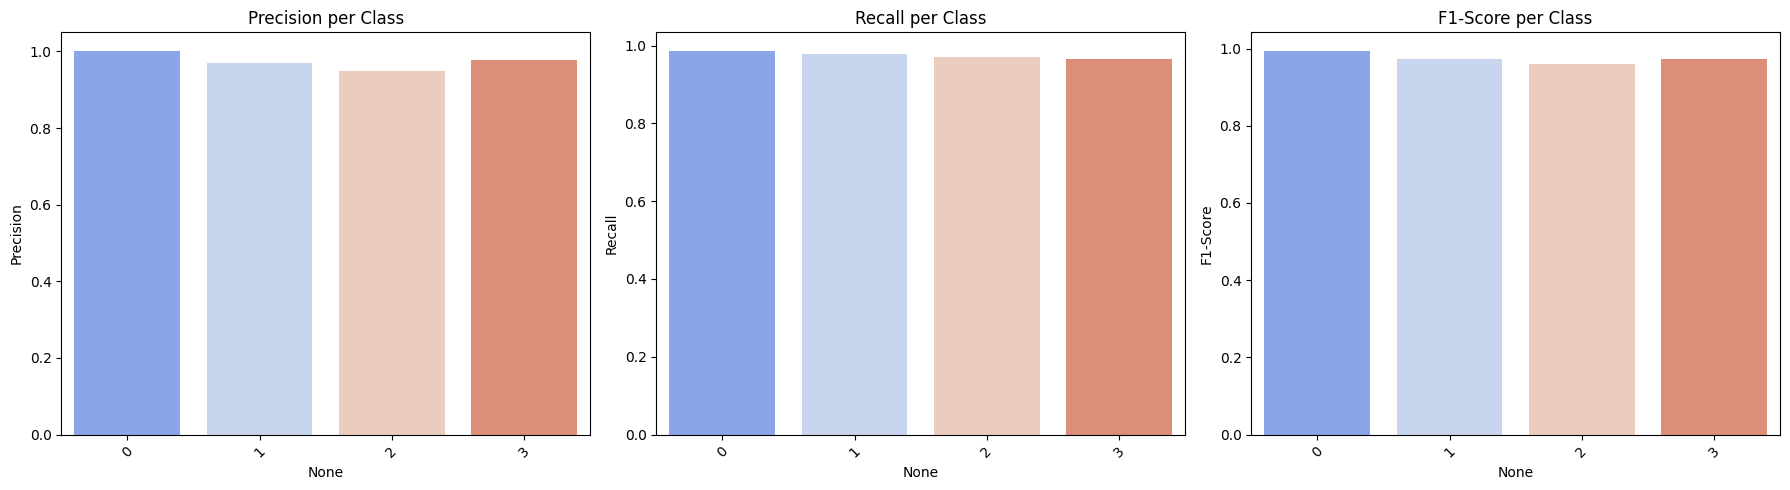

In [79]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Remove 'accuracy', 'macro avg', 'weighted avg' from report for plotting
report.pop('accuracy', None)
report.pop('macro avg', None)
report.pop('weighted avg', None)

metrics_df = pd.DataFrame(report).transpose()

metrics_df[['precision', 'recall', 'f1-score']] = metrics_df[['precision', 'recall', 'f1-score']].apply(pd.to_numeric)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x=metrics_df.index, y='precision', data=metrics_df, ax=ax[0], palette='coolwarm')
ax[0].set_title('Precision per Class')
ax[0].set_ylabel('Precision')
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(x=metrics_df.index, y='recall', data=metrics_df, ax=ax[1], palette='coolwarm')
ax[1].set_title('Recall per Class')
ax[1].set_ylabel('Recall')
ax[1].tick_params(axis='x', rotation=45)

sns.barplot(x=metrics_df.index, y='f1-score', data=metrics_df, ax=ax[2], palette='coolwarm')
ax[2].set_title('F1-Score per Class')
ax[2].set_ylabel('F1-Score')
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [80]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory, shuffle = False, target_size = (256, 256), class_mode = 'categorical')

print("Test generator re-initialized with shuffle=False.")

Found 40 images belonging to 4 classes.
Test generator re-initialized with shuffle=False.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7500 - loss: 1.5953
Accuracy Test : 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.82      0.90      0.86        10
           2       0.50      0.60      0.55        10
           3       0.83      0.50      0.62        10

    accuracy                           0.75        40
   macro avg       0.77      0.75      0.74        40
weighted avg       0.77      0.75      0.74        40



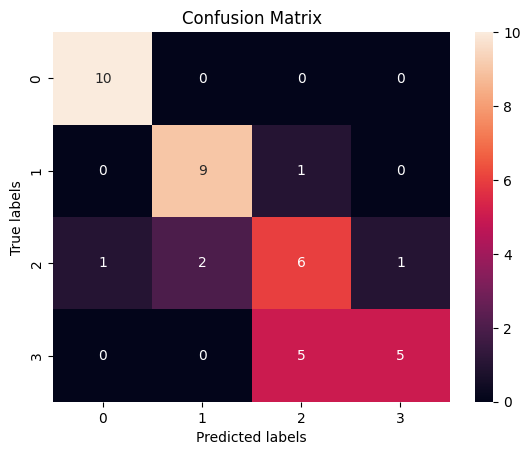

In [81]:
evaluate = model.evaluate(test_generator, steps = len(test_generator), verbose = 1)
print('Accuracy Test : {}'.format(evaluate[1]))

# Reset the generator before prediction to ensure predictions are from the start of the dataset
test_generator.reset()
predictions = model.predict(test_generator, steps = len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

## Visualize Training History


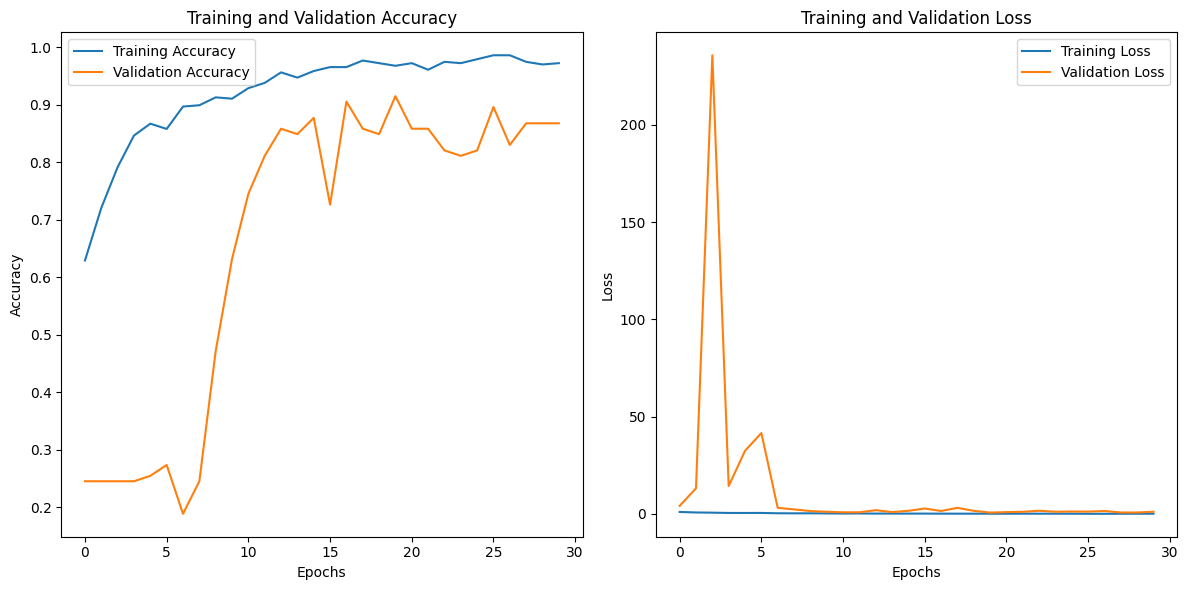

In [82]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
# Save the model file
model.save('lung_disease_model.keras')

# Trigger the download to your computer
from google.colab import files
files.download('lung_disease_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
# Save the model file
model.save('lung_disease_model.h5')

# Trigger the download to your computer
from google.colab import files
files.download('lung_disease_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>